# Linear stability analysis

Import packages

In [1]:
import numpy as np
from numpy import linalg as LA
from src.utils import get_homogeneous_system, max_real_eigenvalue, non_spatial_parts
from scipy.integrate import odeint
import sympy as sp
import matplotlib.pyplot as plt

hfont = {'fontname':'Helvetica'}
b1s = sp.Symbol('b_1', real=True)
s1s = sp.Symbol('s_1', real=True)
b2s = sp.Symbol('b_2', real=True)
s2s = sp.Symbol('s_2', real=True)

Define parameters

In [2]:
# Initialize an empty parameter dictionary
params = {}

# Assign values to parameters
params['p'] = 149  # Precipitation (varied between 30-250)
params['Z1'] = 200; params['Z2'] = 300  # Vertical length of i-th soil layer
params['n1'] = 0.5; params['n2'] = 0.3  # Porosity of i-th soil layer
params['e1'] = 8.0; params['e2'] = 5.0  # Root augmentation per unit biomass of phenotype i
params['k1'] = 0.4; params['k2'] = 0.7  # Maximum standing biomass of phenotype i
params['m1'] = 10.0; params['m2'] = 2.0  # Mortality rate of phenotype i 
params['N'] = 15.0  # Maximum evaporation rate of upper soil moisture
params['lam1'] = 0.38; params['lam2'] = 0.24  # Growth rate per unit soil-water in the i-th layer
params['gam1'] = 12; params['gam2'] = 12  # Soil water consumption rate in the i-th layer per unit biomass
params['r1'] = 0.2; params['r2'] = 0.2  # Evaporation reduction due to shading (ρ)
params['l1'] = 1.0; params['l2'] = 1.0  # Mean dispersal distance of the i-th phenotype
params['Rmin'] = 0.25; params['Rmax'] = 0.5  # Maximum(minimum) germination probabilities
params['fe1'] = 0.25; params['fe2'] = 0.25  # Fecundity (f)
params['gs'] = 40  # Specific conversion rate of seeds into seedlings
params['db1'] = params['gs'] * params['fe1']; params['db2'] = params['gs'] * params['fe2']
params['dr'] = 0.001  # Re-sprouting rate from rhizome buds of dormant phenotype 2 individuals
params['ds1'] = 1000; params['ds2'] = 1/5  # Diffusion rate of soil moisture in i-th soil layer
params['br'] = 0.3  # Biomass of mean germination probability
params['theta1'] = 1/4; params['theta2'] = 1.0 - params['theta1']  # Fraction of water consumed from the upper layer by phenotype 2 (θ)
params['beta1'] = 6000; params['beta2'] = 2000  # Percolation rate from the ith soil layer to the next deeper soil layer
params['a'] = 7.0  # Maximum rate of phenotypic transition
params['s1star'] = 0.03; params['s2star'] = 0.0023  # Half-saturation constant of soil water in the i-th layer

Calculate homogeneous steady state

In [3]:
tstop = 200
y_guess = [0.3, 0.05, 0.3, 0.05]
steady_state = odeint(get_homogeneous_system(params), y0=y_guess, t=np.arange(0, 2000, 0.001))[-1, :]  # take last time point

Calculate Jacobian with sympy

In [4]:
f1 = sp.lambdify((b1s, s1s, b2s, s2s), non_spatial_parts([b1s, s1s, b2s, s2s], params)[0])
g1 = sp.lambdify((b1s, s1s, b2s, s2s), non_spatial_parts([b1s, s1s, b2s, s2s], params)[1])
f2 = sp.lambdify((b1s, s1s, b2s, s2s), non_spatial_parts([b1s, s1s, b2s, s2s], params)[2])
g2 = sp.lambdify((b1s, s1s, b2s, s2s), non_spatial_parts([b1s, s1s, b2s, s2s], params)[3])
    
f_matrix = sp.Matrix([f1(b1s, s1s, b2s, s2s), g1(b1s, s1s, b2s, s2s),
                     f2(b1s, s1s, b2s, s2s), g2(b1s, s1s, b2s, s2s)])

J0=f_matrix.jacobian([b1s, s1s, b2s, s2s]).subs([(b1s, steady_state[0]), (s1s, steady_state[1]), (b2s, steady_state[2]), (s2s, steady_state[3])])

J0=np.array(J0).astype(np.float64)

Calculate eigenvalues

In [31]:
kmin=0.0; kmax=40; kstep=0.001
k = np.arange(kmin, kmax, kstep)
wavelength = 2 * np.pi / k
k, max_real_eigenvalues, flags, max_evectors = max_real_eigenvalue(J0, steady_state, params, k)

/tmp/ipykernel_26186/486162611.py:3: RuntimeWarning: divide by zero encountered in divide
  wavelength = 2 * np.pi / k
/home/jamie/Projects/multiscale-fairy-circles/src/utils.py:100: ComplexWarning: Casting complex values to real discards the imaginary part
  max_evectors[i, :] = evectors[:, jj]


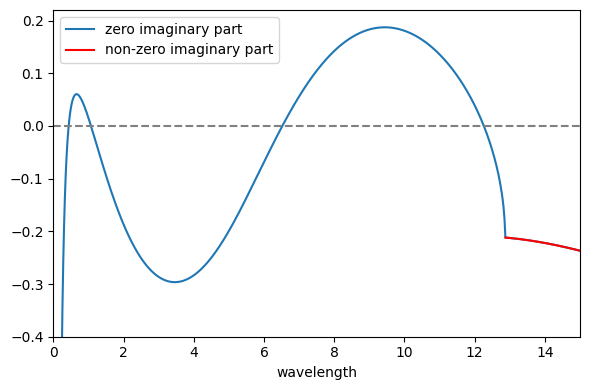

In [43]:
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the data where eigenvalues have zero imaginary part
ax.plot(wavelength, max_real_eigenvalues, label='zero imaginary part')

# Plot the data where eigenvalues have non-zero imaginary part
ax.plot([wavelength[i] for i in range(len(flags)) if flags[i] == 0], 
        [max_real_eigenvalues[i] for i in range(len(flags)) if flags[i] == 0], 
        color='red', label='non-zero imaginary part')

ax.hlines(0, xmin=0, xmax=15, color='gray', linestyles='--')

ax.set_xlim(0, 15)
ax.set_ylim(-0.4, 0.22)

# ax.set_xlabel(")
ax.set_xlabel("wavelength")

ax.legend()

fig.tight_layout()

plt.savefig('../images/stability.png')